In [15]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [16]:
import os
import gc
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras.backend as K

import cv2

import open3d as o3

from functools import partial

from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split

from fastai.vision import Path
from keras.models import *
from keras.layers import *
from keras.losses import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [17]:
def show_pcd_3d(x_data, save=False, name=None):
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(x_data))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = x_data[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')
        ax.set_title(idx)
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_pcd.png')


def show_match_result(pred, tar, save=False, name=None):
    '''
    pcd shape must have dimension of number of pcd, 
    like (num, x, x, x, 3), (num, -1), (num, -1, 3)
    '''
    assert len(pred) == len(tar)
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(tar))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = tar[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')

        data = pred[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]
        ax.scatter(x, y, z, c='b', marker='o')

        ax.set_title(f'index: {idx}, RMS: {eva_rms(pred[idx], tar[idx]):.2f}')
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_match_result.png')

In [18]:
def eva_rms(pred, tar):
    pred_tmp = pred.reshape(-1)
    tar_tmp = tar.reshape(-1)
    assert pred_tmp.shape == tar_tmp.shape

    return np.sqrt(np.mean((pred_tmp - tar_tmp)**2))

In [19]:
def q_norm(q):
    return np.sum(np.square(q))


def q_inv(q):
    invq = np.array([-q[0], -q[1], -q[2], q[3]]) / q_norm(q)
    return invq


def q_mut(q1, q2):
    assert len(q1) == 4 == len(q2)
    a1, b1, c1, d1 = q1
    a2, b2, c2, d2 = q2
    
    qw = (a1 * a2 - b1 * b2 - c1 * c2 - d1 * d2)
    qx = (a1 * b2 + b1 * a2 + c1 * d2 - d1 * c2)
    qy = (a1 * c2 - b1 * d2 + c1 * a2 + d1 * b2)
    qz = (a1 * d2 + b1 * c2 - c1 * b2 + d1 * a2)
    
    return np.array([qw, qx, qy, qz])


def rotate_with_q(xyz, q):
    xyz_tmp = np.append(xyz, 0)
    q_tmp = q_mut(q, q_mut(xyz_tmp, q_inv(q)))
    return q_tmp[:3]

In [20]:
def show_match_result(pred, tar, save=False, name=None):
    '''
    pcd shape must have dimension of number of pcd, 
    like (num, x, x, x, 3), (num, -1), (num, -1, 3)
    '''
    assert len(pred) == len(tar)
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(tar))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = tar[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')

        data = pred[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]
        ax.scatter(x, y, z, c='b', marker='o')

        ax.set_title(f'index: {idx}, RMS: {eva_rms(pred[idx], tar[idx]):.2f}')
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_match_result.png')

In [21]:
def show_pcd_3d(x_data, save=False, name='123'):
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(x_data))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = x_data[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')
        ax.set_title(idx)
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_pcd.png')

In [22]:
def scalar_reduction(x_hat, x_max, x_min):
    reduction = x_hat * (x_max - x_min) + x_min
    return np.float32(reduction)

In [25]:
def get_files_names(path):
    fnames=[]
    for idx, name in enumerate(path.ls()):
        if name.suffix == '.txt':
            fnames.append(name)
    return fnames

In [40]:
def z_norm(x, max_x, min_x):
    norm = (x - min_x) / (max_x - min_x)
    return np.float32(norm)

## Load data

In [27]:
# load and saveing path
print("Load path: \n")
load_path = Path('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/')
load_path.ls(), len(load_path.ls())

Load path: 



([WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_partial_1728.txt'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_points_1253.pcd'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_points_1253.txt'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_points_3135.pcd'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_points_3135.txt'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_test_9000.txt'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_train_50000.txt'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_whole_1728.txt'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generato

In [28]:
fname = get_files_names(load_path)
fname 

[WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_partial_1728.txt'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_points_1253.txt'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_points_3135.txt'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_test_9000.txt'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_train_50000.txt'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000_whole_1728.txt'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bun000__1728.txt'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/bunny_train_30000.txt'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/featu

In [31]:
fname[8], fname[9], fname[13], fname[14]

(WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/labelte_9000.txt'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/labeltr_30000.txt'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/test_9000.txt'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map/train_data/train_30000.txt'))

In [32]:
x_data = np.loadtxt(fname[14])

In [33]:
x_label = np.loadtxt(fname[9])

In [47]:
x_test = np.loadtxt(fname[13])

In [48]:
y_test = np.loadtxt(fname[8])

In [34]:
x_train, x_dev, y_train, y_dev = train_test_split(x_data, x_label, test_size=0.1, random_state=1)

In [38]:
x_train.shape, x_dev.shape, y_train.shape, y_dev.shape

((27000, 5184), (3000, 5184), (27000, 9), (3000, 9))

In [87]:
x_train = x_train.reshape(27000, 12, 12, 12, 3)
x_dev = x_dev.reshape(3000, 12, 12, 12, 3)
y_train = y_train.reshape(27000, 9)
y_dev = y_dev.reshape(3000, 9)
x_test = x_test.reshape(9000, 12, 12, 12, 3)
y_test = y_test.reshape(9000, 9)


In [41]:
x_train_max = np.max(x_train)
x_train_min = np.min(x_train)


In [42]:
np.savez(f'{fname[0].stem}_q_scalar.npz', xmax=x_train_max, xmin=x_train_min, volsz=0.006)

In [43]:
np.max(x_train), np.min(x_train), np.std(x_train), np.median(x_train), np.mean(x_train)

(0.10306495989037685,
 -0.09625815459657354,
 0.020561292412471042,
 0.0,
 0.00010407234604851661)

In [44]:
x_train = z_norm(x_train, x_train_max, x_train_min)
np.max(x_train), np.min(x_train), np.std(x_train), np.median(x_train), np.mean(x_train)

(1.0, 0.0, 0.1031555, 0.4829252, 0.4834477)

In [45]:
x_dev = z_norm(x_dev, x_train_max, x_train_min)

In [49]:
np.max(x_test), np.min(x_test), np.std(x_test), np.median(x_test), np.mean(x_test)

(0.10312747749237419,
 -0.09625361536844478,
 0.02055461535713689,
 0.0,
 0.00012966713768906347)

In [50]:
x_test = z_norm(x_test, x_train_max, x_train_min)
np.max(x_test), np.min(x_test), np.std(x_test), np.median(x_test), np.mean(x_test)

(1.0003136, 2.2773214e-05, 0.103122056, 0.4829252, 0.4835756)

In [51]:
np.max(y_train), np.min(y_train)

(8.999739885256838, -8.999999997863203)

## Training

In [52]:
def cnn_model(input_shape=(12, 12, 12, 3)):
    inputs = Input(shape=input_shape)
    
    #  第一層
    C1 = Conv3D(32, (5, 5, 5), padding='same', name='conv3d_1', kernel_initializer='glorot_normal')(inputs)
    C1 = BatchNormalization(name='batch_normalization_c1')(C1)
    C11 = Activation('relu')(C1)
    
    # 第二層
    C1 = Conv3D(32, (3, 3, 3), padding='same', name='conv2d_2', kernel_initializer='glorot_normal')(C11)
    C1 = BatchNormalization(name='batch_normalization_c2')(C1)    
    C12 = Activation('relu')(C1)   
    
    # 接起來 1、2層，因為把Feature傳下去，效果為Loss function會變平滑，在硬體可以承受的範圍內可以無限加深、加速。Deeper and Deeper.
    Concat1 = concatenate([C11, C12])
    
    # 1*1*1的原因是因為接起來的參數太多，所以要壓扁，至於為什麼要這樣做自己去讀論文。
    Concat1 = Conv3D(16, (1, 1, 1), padding='same', name='conv3d_1x1_1', kernel_initializer='glorot_normal')(Concat1)
    # C1 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(Concat1)
    
    # 第三層
    C2 = Conv3D(64, (5, 5, 5), padding='same', name='conv3d_3', kernel_initializer='glorot_normal')(Concat1)
    C2 = BatchNormalization(name='batch_normalization_c3')(C2)
    C21 = Activation('relu')(C2)   
    
    # 接起來 壓扁
    Concat2 = concatenate([Concat1, C21])
    Concat2 = Conv3D(32, (1, 1, 1), padding='same', name='conv3d_1x1_2', kernel_initializer='glorot_normal')(Concat2)
    
    # 第四層
    C2 = Conv3D(64, (3, 3, 3), padding='same', name='conv3d_4', kernel_initializer='glorot_normal')(Concat2)
    C2 = BatchNormalization(name='batch_normalization_c4')(C2)
    C22 = Activation('relu')(C2)    

    # 接起來 壓扁
    Concat3 = concatenate([Concat2, C22])
    Concat3 = Conv3D(32, (1, 1, 1), padding='same', name='conv3d_1x1_3', kernel_initializer='glorot_normal')(Concat3)    
    
    C2 = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(Concat3)
    
    # Global Average pooling3D 現在默認都用這個，原因自己查。
    C = GlobalAveragePooling3D(name='G_ave_pol')(C2)                         
    # C = Flatten()(C2)
    
    FC5 = Dense(256, activation='relu', name='dense_1', kernel_initializer='glorot_normal')(C)
    FC5 = BatchNormalization(name='batch_normalization_d1')(FC5)
    FC5 = Activation('relu')(FC5)
    # FC5 = Dropout(0.15)(FC5)
    
    Output = Dense(9, activation='relu', name='dense_3', kernel_initializer='glorot_normal')(FC5)
        
    model = Model(inputs=inputs, outputs=Output)
    
    return model

In [53]:
model = cnn_model()

In [54]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 12, 12, 12, 3 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 12, 12, 12, 3 12032       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_c1 (BatchNo (None, 12, 12, 12, 3 128         conv3d_1[0][0]                   
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 12, 12, 12, 3 0           batch_normalization_c1[0][0]     
____________________________________________________________________________________________

In [55]:
model_checkpoint = ModelCheckpoint(f'{fname[0].stem}_callback_model.h5',verbose=1, monitor='val_mean_absolute_error',  mode='auto',save_best_only=True)

In [56]:
reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.5 ,patience=4, min_lr=1e-6, verbose=True)

In [58]:
# model.compile(optimizer=Adam(3e-4, decay=3e-5, amsgrad=True, clipnorm=1.), loss='mse', metrics=['accuracy', 'mse', 'mae']) 
model.compile(optimizer=SGD(3e-3, decay= 1e-7, momentum=0.9, nesterov=True), loss='mae', metrics=['accuracy', 'mse', 'mae']) 
# model.compile(optimizer=Adadelta(), loss='mse', metrics=['accuracy', 'mse', 'mae'])

In [65]:
%%time
history = model.fit(x = x_train, y = y_train, batch_size = 512, epochs=60, verbose=1,
                    callbacks=[reduce_lr, model_checkpoint],
                    validation_data=(x_dev, y_dev))


Train on 27000 samples, validate on 3000 samples
Epoch 1/60
27000/27000 [==============================] - ETA: 5:34 - loss: 3.0229 - accuracy: 0.0371 - mse: 14.2134 - mae: 3.022 - ETA: 2:58 - loss: 3.0194 - accuracy: 0.0352 - mse: 14.1412 - mae: 3.019 - ETA: 2:05 - loss: 3.0065 - accuracy: 0.0326 - mse: 14.0832 - mae: 3.006 - ETA: 1:39 - loss: 3.0009 - accuracy: 0.0332 - mse: 14.0305 - mae: 3.000 - ETA: 1:23 - loss: 2.9879 - accuracy: 0.0359 - mse: 13.9708 - mae: 2.987 - ETA: 1:12 - loss: 2.9763 - accuracy: 0.0417 - mse: 13.9170 - mae: 2.976 - ETA: 1:04 - loss: 2.9681 - accuracy: 0.0483 - mse: 13.8662 - mae: 2.968 - ETA: 58s - loss: 2.9596 - accuracy: 0.0574 - mse: 13.8128 - mae: 2.959 - ETA: 53s - loss: 2.9511 - accuracy: 0.0651 - mse: 13.7582 - mae: 2.95 - ETA: 49s - loss: 2.9441 - accuracy: 0.0738 - mse: 13.6993 - mae: 2.94 - ETA: 46s - loss: 2.9342 - accuracy: 0.0824 - mse: 13.6461 - mae: 2.93 - ETA: 43s - loss: 2.9243 - accuracy: 0.0908 - mse: 13.5898 - mae: 2.92 - ETA: 40s - lo

C:\Users\dreamer\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_mean_absolute_error` which is not available. Available metrics are: val_loss,val_accuracy,val_mse,val_mae,loss,accuracy,mse,mae,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
C:\Users\dreamer\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_mean_absolute_error available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/60
27000/27000 [==============================] - ETA: 28s - loss: 2.2909 - accuracy: 0.5039 - mse: 10.0768 - mae: 2.29 - ETA: 28s - loss: 2.2703 - accuracy: 0.5186 - mse: 10.0120 - mae: 2.27 - ETA: 27s - loss: 2.2662 - accuracy: 0.5228 - mse: 10.0499 - mae: 2.26 - ETA: 27s - loss: 2.2602 - accuracy: 0.5288 - mse: 10.0085 - mae: 2.26 - ETA: 26s - loss: 2.2567 - accuracy: 0.5332 - mse: 9.9481 - mae: 2.2567 - ETA: 26s - loss: 2.2503 - accuracy: 0.5339 - mse: 9.9315 - mae: 2.250 - ETA: 25s - loss: 2.2426 - accuracy: 0.5363 - mse: 9.8859 - mae: 2.242 - ETA: 25s - loss: 2.2437 - accuracy: 0.5405 - mse: 9.8873 - mae: 2.243 - ETA: 24s - loss: 2.2393 - accuracy: 0.5417 - mse: 9.8684 - mae: 2.239 - ETA: 23s - loss: 2.2349 - accuracy: 0.5420 - mse: 9.8462 - mae: 2.234 - ETA: 23s - loss: 2.2294 - accuracy: 0.5400 - mse: 9.8142 - mae: 2.229 - ETA: 22s - loss: 2.2244 - accuracy: 0.5428 - mse: 9.7859 - mae: 2.224 - ETA: 22s - loss: 2.2196 - accuracy: 0.5466 - mse: 9.7552 - mae: 2.219 - ETA: 

27000/27000 [==============================] - ETA: 29s - loss: 1.1609 - accuracy: 0.9844 - mse: 5.1290 - mae: 1.160 - ETA: 28s - loss: 1.1426 - accuracy: 0.9795 - mse: 4.9379 - mae: 1.142 - ETA: 28s - loss: 1.1499 - accuracy: 0.9701 - mse: 4.9186 - mae: 1.149 - ETA: 27s - loss: 1.1631 - accuracy: 0.9712 - mse: 4.9529 - mae: 1.163 - ETA: 26s - loss: 1.1586 - accuracy: 0.9723 - mse: 4.9091 - mae: 1.158 - ETA: 26s - loss: 1.1635 - accuracy: 0.9723 - mse: 4.9499 - mae: 1.163 - ETA: 25s - loss: 1.1665 - accuracy: 0.9724 - mse: 4.9751 - mae: 1.166 - ETA: 25s - loss: 1.1662 - accuracy: 0.9717 - mse: 4.9596 - mae: 1.166 - ETA: 24s - loss: 1.1628 - accuracy: 0.9705 - mse: 4.9477 - mae: 1.162 - ETA: 23s - loss: 1.1638 - accuracy: 0.9703 - mse: 4.9458 - mae: 1.163 - ETA: 23s - loss: 1.1627 - accuracy: 0.9696 - mse: 4.9377 - mae: 1.162 - ETA: 22s - loss: 1.1647 - accuracy: 0.9702 - mse: 4.9544 - mae: 1.164 - ETA: 22s - loss: 1.1643 - accuracy: 0.9709 - mse: 4.9349 - mae: 1.164 - ETA: 21s - loss: 

27000/27000 [==============================] - ETA: 29s - loss: 1.1807 - accuracy: 0.9707 - mse: 5.1783 - mae: 1.180 - ETA: 29s - loss: 1.1647 - accuracy: 0.9678 - mse: 4.9364 - mae: 1.164 - ETA: 28s - loss: 1.1625 - accuracy: 0.9668 - mse: 4.8524 - mae: 1.162 - ETA: 28s - loss: 1.1625 - accuracy: 0.9702 - mse: 4.8804 - mae: 1.162 - ETA: 27s - loss: 1.1576 - accuracy: 0.9723 - mse: 4.8743 - mae: 1.157 - ETA: 26s - loss: 1.1551 - accuracy: 0.9733 - mse: 4.8932 - mae: 1.155 - ETA: 26s - loss: 1.1615 - accuracy: 0.9738 - mse: 4.9381 - mae: 1.161 - ETA: 25s - loss: 1.1636 - accuracy: 0.9739 - mse: 4.9459 - mae: 1.163 - ETA: 25s - loss: 1.1677 - accuracy: 0.9733 - mse: 4.9823 - mae: 1.167 - ETA: 24s - loss: 1.1673 - accuracy: 0.9730 - mse: 5.0071 - mae: 1.167 - ETA: 24s - loss: 1.1679 - accuracy: 0.9714 - mse: 5.0051 - mae: 1.167 - ETA: 23s - loss: 1.1665 - accuracy: 0.9723 - mse: 5.0094 - mae: 1.166 - ETA: 22s - loss: 1.1646 - accuracy: 0.9724 - mse: 5.0009 - mae: 1.164 - ETA: 22s - loss: 

27000/27000 [==============================] - ETA: 28s - loss: 1.1379 - accuracy: 0.9824 - mse: 4.8610 - mae: 1.137 - ETA: 28s - loss: 1.1427 - accuracy: 0.9736 - mse: 4.9527 - mae: 1.142 - ETA: 28s - loss: 1.1336 - accuracy: 0.9766 - mse: 4.9087 - mae: 1.133 - ETA: 27s - loss: 1.1398 - accuracy: 0.9790 - mse: 4.9593 - mae: 1.139 - ETA: 27s - loss: 1.1372 - accuracy: 0.9809 - mse: 4.9412 - mae: 1.137 - ETA: 26s - loss: 1.1326 - accuracy: 0.9775 - mse: 4.8992 - mae: 1.132 - ETA: 25s - loss: 1.1393 - accuracy: 0.9757 - mse: 4.8947 - mae: 1.139 - ETA: 25s - loss: 1.1549 - accuracy: 0.9756 - mse: 4.9367 - mae: 1.154 - ETA: 24s - loss: 1.1498 - accuracy: 0.9761 - mse: 4.9261 - mae: 1.149 - ETA: 24s - loss: 1.1466 - accuracy: 0.9777 - mse: 4.9222 - mae: 1.146 - ETA: 23s - loss: 1.1456 - accuracy: 0.9783 - mse: 4.9312 - mae: 1.145 - ETA: 22s - loss: 1.1424 - accuracy: 0.9772 - mse: 4.9071 - mae: 1.142 - ETA: 22s - loss: 1.1414 - accuracy: 0.9772 - mse: 4.9072 - mae: 1.141 - ETA: 21s - loss: 

27000/27000 [==============================] - ETA: 28s - loss: 1.1941 - accuracy: 0.9648 - mse: 5.0793 - mae: 1.194 - ETA: 28s - loss: 1.1820 - accuracy: 0.9717 - mse: 5.1329 - mae: 1.182 - ETA: 27s - loss: 1.1553 - accuracy: 0.9785 - mse: 4.9758 - mae: 1.155 - ETA: 27s - loss: 1.1491 - accuracy: 0.9775 - mse: 4.9866 - mae: 1.149 - ETA: 26s - loss: 1.1534 - accuracy: 0.9785 - mse: 5.0007 - mae: 1.153 - ETA: 26s - loss: 1.1481 - accuracy: 0.9795 - mse: 4.9628 - mae: 1.148 - ETA: 25s - loss: 1.1427 - accuracy: 0.9785 - mse: 4.9332 - mae: 1.142 - ETA: 24s - loss: 1.1474 - accuracy: 0.9778 - mse: 4.9405 - mae: 1.147 - ETA: 24s - loss: 1.1476 - accuracy: 0.9779 - mse: 4.9568 - mae: 1.147 - ETA: 23s - loss: 1.1460 - accuracy: 0.9773 - mse: 4.9569 - mae: 1.146 - ETA: 23s - loss: 1.1448 - accuracy: 0.9776 - mse: 4.9548 - mae: 1.144 - ETA: 22s - loss: 1.1465 - accuracy: 0.9772 - mse: 4.9531 - mae: 1.146 - ETA: 22s - loss: 1.1463 - accuracy: 0.9779 - mse: 4.9628 - mae: 1.146 - ETA: 21s - loss: 

27000/27000 [==============================] - ETA: 28s - loss: 1.1414 - accuracy: 0.9805 - mse: 5.0017 - mae: 1.141 - ETA: 28s - loss: 1.1243 - accuracy: 0.9844 - mse: 4.8947 - mae: 1.124 - ETA: 27s - loss: 1.1420 - accuracy: 0.9759 - mse: 4.9097 - mae: 1.142 - ETA: 27s - loss: 1.1360 - accuracy: 0.9761 - mse: 4.8713 - mae: 1.136 - ETA: 26s - loss: 1.1324 - accuracy: 0.9738 - mse: 4.8483 - mae: 1.132 - ETA: 26s - loss: 1.1364 - accuracy: 0.9746 - mse: 4.8759 - mae: 1.136 - ETA: 25s - loss: 1.1330 - accuracy: 0.9749 - mse: 4.8644 - mae: 1.133 - ETA: 24s - loss: 1.1392 - accuracy: 0.9736 - mse: 4.9010 - mae: 1.139 - ETA: 24s - loss: 1.1374 - accuracy: 0.9731 - mse: 4.9061 - mae: 1.137 - ETA: 23s - loss: 1.1342 - accuracy: 0.9744 - mse: 4.8896 - mae: 1.134 - ETA: 23s - loss: 1.1345 - accuracy: 0.9755 - mse: 4.9021 - mae: 1.134 - ETA: 22s - loss: 1.1347 - accuracy: 0.9738 - mse: 4.8884 - mae: 1.134 - ETA: 22s - loss: 1.1419 - accuracy: 0.9737 - mse: 4.9180 - mae: 1.141 - ETA: 21s - loss: 

27000/27000 [==============================] - ETA: 29s - loss: 1.1052 - accuracy: 0.9844 - mse: 4.7596 - mae: 1.105 - ETA: 29s - loss: 1.1371 - accuracy: 0.9785 - mse: 4.8602 - mae: 1.137 - ETA: 28s - loss: 1.1375 - accuracy: 0.9811 - mse: 4.8890 - mae: 1.137 - ETA: 27s - loss: 1.1327 - accuracy: 0.9790 - mse: 4.8816 - mae: 1.132 - ETA: 27s - loss: 1.1356 - accuracy: 0.9797 - mse: 4.9301 - mae: 1.135 - ETA: 26s - loss: 1.1332 - accuracy: 0.9785 - mse: 4.9172 - mae: 1.133 - ETA: 25s - loss: 1.1357 - accuracy: 0.9782 - mse: 4.9390 - mae: 1.135 - ETA: 25s - loss: 1.1396 - accuracy: 0.9780 - mse: 4.9292 - mae: 1.139 - ETA: 24s - loss: 1.1374 - accuracy: 0.9772 - mse: 4.8893 - mae: 1.137 - ETA: 24s - loss: 1.1359 - accuracy: 0.9775 - mse: 4.8823 - mae: 1.135 - ETA: 23s - loss: 1.1333 - accuracy: 0.9780 - mse: 4.8804 - mae: 1.133 - ETA: 23s - loss: 1.1305 - accuracy: 0.9784 - mse: 4.8693 - mae: 1.130 - ETA: 22s - loss: 1.1302 - accuracy: 0.9784 - mse: 4.8699 - mae: 1.130 - ETA: 21s - loss: 

27000/27000 [==============================] - ETA: 29s - loss: 1.1442 - accuracy: 0.9805 - mse: 4.9701 - mae: 1.144 - ETA: 28s - loss: 1.1439 - accuracy: 0.9775 - mse: 4.9195 - mae: 1.143 - ETA: 28s - loss: 1.1319 - accuracy: 0.9818 - mse: 4.9171 - mae: 1.131 - ETA: 28s - loss: 1.1406 - accuracy: 0.9780 - mse: 4.9746 - mae: 1.140 - ETA: 27s - loss: 1.1373 - accuracy: 0.9773 - mse: 4.9815 - mae: 1.137 - ETA: 27s - loss: 1.1397 - accuracy: 0.9759 - mse: 4.9996 - mae: 1.139 - ETA: 26s - loss: 1.1379 - accuracy: 0.9768 - mse: 4.9980 - mae: 1.137 - ETA: 25s - loss: 1.1375 - accuracy: 0.9783 - mse: 4.9940 - mae: 1.137 - ETA: 25s - loss: 1.1360 - accuracy: 0.9789 - mse: 4.9888 - mae: 1.136 - ETA: 24s - loss: 1.1340 - accuracy: 0.9791 - mse: 4.9810 - mae: 1.134 - ETA: 23s - loss: 1.1342 - accuracy: 0.9798 - mse: 4.9828 - mae: 1.134 - ETA: 23s - loss: 1.1338 - accuracy: 0.9797 - mse: 4.9736 - mae: 1.133 - ETA: 22s - loss: 1.1333 - accuracy: 0.9799 - mse: 4.9685 - mae: 1.133 - ETA: 22s - loss: 

27000/27000 [==============================] - ETA: 31s - loss: 1.1162 - accuracy: 0.9902 - mse: 4.8427 - mae: 1.116 - ETA: 30s - loss: 1.1466 - accuracy: 0.9795 - mse: 4.8620 - mae: 1.146 - ETA: 29s - loss: 1.1304 - accuracy: 0.9785 - mse: 4.7862 - mae: 1.130 - ETA: 29s - loss: 1.1454 - accuracy: 0.9771 - mse: 4.8986 - mae: 1.145 - ETA: 28s - loss: 1.1529 - accuracy: 0.9762 - mse: 4.9196 - mae: 1.152 - ETA: 28s - loss: 1.1501 - accuracy: 0.9788 - mse: 4.9258 - mae: 1.150 - ETA: 27s - loss: 1.1446 - accuracy: 0.9785 - mse: 4.9176 - mae: 1.144 - ETA: 27s - loss: 1.1463 - accuracy: 0.9783 - mse: 4.9127 - mae: 1.146 - ETA: 26s - loss: 1.1459 - accuracy: 0.9789 - mse: 4.9139 - mae: 1.145 - ETA: 25s - loss: 1.1422 - accuracy: 0.9787 - mse: 4.9037 - mae: 1.142 - ETA: 25s - loss: 1.1462 - accuracy: 0.9787 - mse: 4.9332 - mae: 1.146 - ETA: 24s - loss: 1.1436 - accuracy: 0.9787 - mse: 4.9235 - mae: 1.143 - ETA: 24s - loss: 1.1412 - accuracy: 0.9790 - mse: 4.9101 - mae: 1.141 - ETA: 23s - loss: 

27000/27000 [==============================] - ETA: 31s - loss: 1.1301 - accuracy: 0.9727 - mse: 4.8367 - mae: 1.130 - ETA: 30s - loss: 1.1315 - accuracy: 0.9746 - mse: 4.8674 - mae: 1.131 - ETA: 29s - loss: 1.1438 - accuracy: 0.9714 - mse: 4.9544 - mae: 1.143 - ETA: 29s - loss: 1.1396 - accuracy: 0.9741 - mse: 4.9443 - mae: 1.139 - ETA: 28s - loss: 1.1358 - accuracy: 0.9754 - mse: 4.8943 - mae: 1.135 - ETA: 28s - loss: 1.1342 - accuracy: 0.9756 - mse: 4.9140 - mae: 1.134 - ETA: 27s - loss: 1.1326 - accuracy: 0.9777 - mse: 4.9190 - mae: 1.132 - ETA: 26s - loss: 1.1305 - accuracy: 0.9792 - mse: 4.9126 - mae: 1.130 - ETA: 26s - loss: 1.1341 - accuracy: 0.9798 - mse: 4.9327 - mae: 1.134 - ETA: 25s - loss: 1.1333 - accuracy: 0.9795 - mse: 4.8956 - mae: 1.133 - ETA: 25s - loss: 1.1328 - accuracy: 0.9796 - mse: 4.8834 - mae: 1.132 - ETA: 24s - loss: 1.1324 - accuracy: 0.9800 - mse: 4.8827 - mae: 1.132 - ETA: 23s - loss: 1.1304 - accuracy: 0.9803 - mse: 4.8703 - mae: 1.130 - ETA: 23s - loss: 

27000/27000 [==============================] - ETA: 31s - loss: 1.1360 - accuracy: 0.9922 - mse: 4.8264 - mae: 1.136 - ETA: 30s - loss: 1.1534 - accuracy: 0.9834 - mse: 4.9956 - mae: 1.153 - ETA: 29s - loss: 1.1462 - accuracy: 0.9746 - mse: 4.9578 - mae: 1.146 - ETA: 29s - loss: 1.1545 - accuracy: 0.9751 - mse: 4.9875 - mae: 1.154 - ETA: 28s - loss: 1.1531 - accuracy: 0.9730 - mse: 4.9407 - mae: 1.153 - ETA: 28s - loss: 1.1527 - accuracy: 0.9740 - mse: 4.9624 - mae: 1.152 - ETA: 27s - loss: 1.1565 - accuracy: 0.9738 - mse: 4.9907 - mae: 1.156 - ETA: 26s - loss: 1.1501 - accuracy: 0.9744 - mse: 4.9471 - mae: 1.150 - ETA: 26s - loss: 1.1501 - accuracy: 0.9737 - mse: 4.9569 - mae: 1.150 - ETA: 25s - loss: 1.1466 - accuracy: 0.9752 - mse: 4.9451 - mae: 1.146 - ETA: 25s - loss: 1.1439 - accuracy: 0.9764 - mse: 4.9400 - mae: 1.143 - ETA: 24s - loss: 1.1434 - accuracy: 0.9767 - mse: 4.9412 - mae: 1.143 - ETA: 23s - loss: 1.1423 - accuracy: 0.9763 - mse: 4.9230 - mae: 1.142 - ETA: 23s - loss: 

27000/27000 [==============================] - ETA: 31s - loss: 1.1417 - accuracy: 0.9883 - mse: 4.9556 - mae: 1.141 - ETA: 30s - loss: 1.1325 - accuracy: 0.9893 - mse: 4.9720 - mae: 1.132 - ETA: 29s - loss: 1.1424 - accuracy: 0.9883 - mse: 4.9868 - mae: 1.142 - ETA: 29s - loss: 1.1368 - accuracy: 0.9858 - mse: 4.9548 - mae: 1.136 - ETA: 28s - loss: 1.1493 - accuracy: 0.9816 - mse: 4.9514 - mae: 1.149 - ETA: 28s - loss: 1.1495 - accuracy: 0.9814 - mse: 4.9195 - mae: 1.149 - ETA: 27s - loss: 1.1488 - accuracy: 0.9819 - mse: 4.9111 - mae: 1.148 - ETA: 27s - loss: 1.1514 - accuracy: 0.9802 - mse: 4.9361 - mae: 1.151 - ETA: 26s - loss: 1.1500 - accuracy: 0.9800 - mse: 4.9413 - mae: 1.150 - ETA: 26s - loss: 1.1472 - accuracy: 0.9801 - mse: 4.9320 - mae: 1.147 - ETA: 25s - loss: 1.1458 - accuracy: 0.9808 - mse: 4.9294 - mae: 1.145 - ETA: 24s - loss: 1.1420 - accuracy: 0.9814 - mse: 4.9231 - mae: 1.142 - ETA: 24s - loss: 1.1435 - accuracy: 0.9809 - mse: 4.9334 - mae: 1.143 - ETA: 23s - loss: 

27000/27000 [==============================] - ETA: 31s - loss: 1.1308 - accuracy: 0.9922 - mse: 5.0408 - mae: 1.130 - ETA: 30s - loss: 1.1437 - accuracy: 0.9883 - mse: 5.0717 - mae: 1.143 - ETA: 30s - loss: 1.1415 - accuracy: 0.9831 - mse: 5.0208 - mae: 1.141 - ETA: 29s - loss: 1.1379 - accuracy: 0.9824 - mse: 5.0082 - mae: 1.137 - ETA: 28s - loss: 1.1450 - accuracy: 0.9836 - mse: 5.0390 - mae: 1.145 - ETA: 28s - loss: 1.1509 - accuracy: 0.9785 - mse: 5.0273 - mae: 1.150 - ETA: 27s - loss: 1.1493 - accuracy: 0.9791 - mse: 5.0321 - mae: 1.149 - ETA: 27s - loss: 1.1471 - accuracy: 0.9802 - mse: 5.0321 - mae: 1.147 - ETA: 26s - loss: 1.1449 - accuracy: 0.9818 - mse: 5.0305 - mae: 1.144 - ETA: 25s - loss: 1.1430 - accuracy: 0.9811 - mse: 5.0216 - mae: 1.143 - ETA: 25s - loss: 1.1408 - accuracy: 0.9810 - mse: 4.9951 - mae: 1.140 - ETA: 24s - loss: 1.1386 - accuracy: 0.9806 - mse: 4.9875 - mae: 1.138 - ETA: 23s - loss: 1.1367 - accuracy: 0.9808 - mse: 4.9788 - mae: 1.136 - ETA: 23s - loss: 

27000/27000 [==============================] - ETA: 31s - loss: 1.1443 - accuracy: 0.9785 - mse: 5.1332 - mae: 1.144 - ETA: 31s - loss: 1.1370 - accuracy: 0.9658 - mse: 4.9107 - mae: 1.137 - ETA: 30s - loss: 1.1372 - accuracy: 0.9655 - mse: 4.8714 - mae: 1.137 - ETA: 30s - loss: 1.1329 - accuracy: 0.9688 - mse: 4.8869 - mae: 1.132 - ETA: 29s - loss: 1.1281 - accuracy: 0.9715 - mse: 4.8924 - mae: 1.128 - ETA: 28s - loss: 1.1258 - accuracy: 0.9730 - mse: 4.8951 - mae: 1.125 - ETA: 28s - loss: 1.1287 - accuracy: 0.9727 - mse: 4.8827 - mae: 1.128 - ETA: 27s - loss: 1.1268 - accuracy: 0.9741 - mse: 4.8772 - mae: 1.126 - ETA: 26s - loss: 1.1281 - accuracy: 0.9746 - mse: 4.8994 - mae: 1.128 - ETA: 26s - loss: 1.1290 - accuracy: 0.9746 - mse: 4.9118 - mae: 1.129 - ETA: 25s - loss: 1.1279 - accuracy: 0.9743 - mse: 4.9068 - mae: 1.127 - ETA: 25s - loss: 1.1273 - accuracy: 0.9754 - mse: 4.9175 - mae: 1.127 - ETA: 24s - loss: 1.1292 - accuracy: 0.9758 - mse: 4.9303 - mae: 1.129 - ETA: 23s - loss: 

27000/27000 [==============================] - ETA: 30s - loss: 1.1322 - accuracy: 0.9785 - mse: 4.9427 - mae: 1.132 - ETA: 28s - loss: 1.1432 - accuracy: 0.9756 - mse: 4.9220 - mae: 1.143 - ETA: 28s - loss: 1.1339 - accuracy: 0.9785 - mse: 4.9264 - mae: 1.133 - ETA: 27s - loss: 1.1228 - accuracy: 0.9790 - mse: 4.8266 - mae: 1.122 - ETA: 27s - loss: 1.1288 - accuracy: 0.9824 - mse: 4.8731 - mae: 1.128 - ETA: 26s - loss: 1.1283 - accuracy: 0.9824 - mse: 4.8926 - mae: 1.128 - ETA: 25s - loss: 1.1293 - accuracy: 0.9833 - mse: 4.9033 - mae: 1.129 - ETA: 25s - loss: 1.1307 - accuracy: 0.9822 - mse: 4.8982 - mae: 1.130 - ETA: 24s - loss: 1.1276 - accuracy: 0.9818 - mse: 4.8806 - mae: 1.127 - ETA: 24s - loss: 1.1295 - accuracy: 0.9793 - mse: 4.8979 - mae: 1.129 - ETA: 23s - loss: 1.1266 - accuracy: 0.9787 - mse: 4.8721 - mae: 1.126 - ETA: 23s - loss: 1.1242 - accuracy: 0.9788 - mse: 4.8524 - mae: 1.124 - ETA: 22s - loss: 1.1315 - accuracy: 0.9784 - mse: 4.8903 - mae: 1.131 - ETA: 21s - loss: 

In [66]:
if not os.path.exists('models'):
    os.makedirs('models')

In [67]:
model.save(f'models/{fname[0].stem}_bunny_frame_model.h5')

In [68]:
model = load_model(f'models/{fname[0].stem}_bunny_frame_model.h5')

In [76]:
result = model.evaluate(x_train, y_train)

27000/27000 [==============================] - ETA: 12 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:

In [79]:
print('Accuracy of training Set:',result[1])
print('Loss of training set:', result[0])

Accuracy of training Set: 0.9571481347084045
Loss of training set: 1.1837259942867138


In [77]:
result_dev = model.evaluate(x_dev, y_dev)

3000/3000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 523us/step
Accuracy of development set:  0.9626666903495789
Loss of development set: 1.1839552170435588


In [80]:
print('Accuracy of development set: ',result_dev[1])
print('Loss of development set:', result_dev[0])

Accuracy of development set:  0.9626666903495789
Loss of development set: 1.1839552170435588


In [81]:
result, result_dev

([1.1837259942867138,
  0.9571481347084045,
  4.961836814880371,
  1.1837259531021118],
 [1.1839552170435588,
  0.9626666903495789,
  4.96037483215332,
  1.1839553117752075])

In [82]:
if not os.path.exists('results'):
    os.makedirs('results')

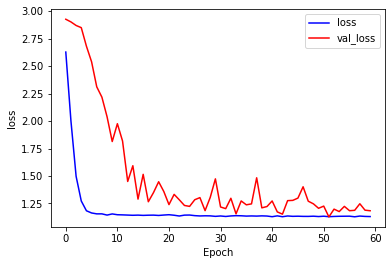

In [83]:
plt.plot( history.history['loss'], color = 'blue', label = 'loss')
plt.plot( history.history['val_loss'], color = 'red', label = 'val_loss')

# plt.plot( model.history['loss'], color = 'blue', label = 'loss')
# plt.plot( model.history['val_loss'], color = 'red', label = 'val_loss')

plt.legend(loc="best")
plt.ylabel('loss')
plt.xlabel('Epoch')
# plt.savefig(f'results/{fname.stem}_loss.png')
plt.show()

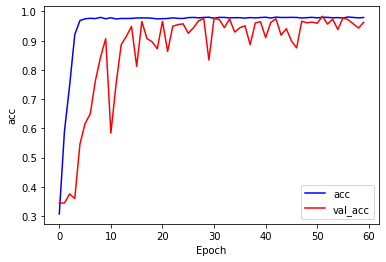

In [84]:
plt.plot( history.history['accuracy'], color = 'blue', label = 'acc')
plt.plot( history.history['val_accuracy'], color = 'red', label = 'val_acc')


plt.legend(loc="best")
plt.ylabel('acc')
plt.xlabel('Epoch')
# plt.savefig(f'results/{fname.stem}_acc.png')
plt.show()

In [90]:
result_test = model.evaluate(x_test, y_test)

9000/9000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 498us/step


In [91]:
print('Accuracy of training Set:',result_test[1])
print('Loss of training set:', result_test[0])

Accuracy of training Set: 0.9591110944747925
Loss of training set: 1.1897408538394505


In [92]:
starttime = datetime.datetime.now()
y_pred = model.predict(x_test)
endtime = datetime.datetime.now()

print("Prediction %d samples execute time: %s sec" % (len(x_test), (endtime - starttime).total_seconds())) 
print("Average prediction execute time: %f ms" % ((endtime - starttime).total_seconds() / len(x_test) * 1000)) 

Prediction 9000 samples execute time: 4.15478 sec
Average prediction execute time: 0.461642 ms


In [95]:
y_pred[1]

array([2.727211, 0.      , 0.      , 1.076741, 5.072021, 1.789335, 0.527295, 2.496869, 0.      ], dtype=float32)

In [96]:
y_test[1]

array([ 2.901791, -0.755337, -0.095265,  1.510674,  5.618764,  1.465385,  0.285795,  2.198077, -8.722774])